# Representations of Vector Fields and Spatial Aggregates

Class on Tuesday mainly focused on various flavors of vector fields and their interpretation before ending with spatial aggregation. Here, we'll discuss how to represent and visualize the different kinds of vectore fields and how to perform spatial aggregation. Along the way, we'll learn about `for` loops more explicitly and defining functions.

Per ususal, let's start by importing libraries.

In [12]:
import rasterio as rio
from rasterio.mask import mask
from rasterio.transform import Affine
from rasterio.plot import show
import numpy as np
import pandas as pd
import shapely.geometry as shg
import geopandas as gpd
import matplotlib.pyplot as plt

In the last notebook, we saw how we could make a 3-band raster and display it as an RGB image using `rasterio.show`. As we talked about on Tuesday, an RGB image is a rasterized vector field, so let's re-run that to get started implementing and visualizing vector fields.

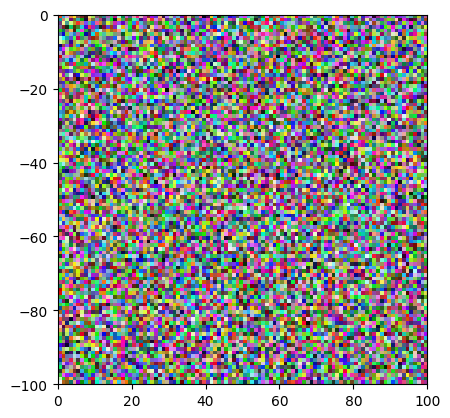

<Axes: >

In [11]:
r100_3 = np.random.rand(100,100,3)

t1 = Affine(
    1, 0, 0,
    0, -1, 0
)

new_dataset = rio.open(
    './r100_3d.tif', 
    'w', 
    driver='GTiff', 
    height=r100_3.shape[1], 
    width=r100_3.shape[1],
    count=3, # Three bands, here our field is vector-valued with 3 components
    dtype=r100_3.dtype,
    crs='EPSG:4326',
    transform=t1 
)

for b in range(0,3): # we'll use b values 0, 1, 2
    new_dataset.write(r100_3[:,:,b],b+1) # this says "get the bth 100x100 2D array and write it as channel b+1"

new_dataset.close()

r100_r3d = rio.open("./r100_3d.tif")
show(r100_r3d)

RGB imagery is a very paricular way to visualize vector fields. For one, it requires that the vector field have exactly 3 components. It can also be hard to interpret the colors if the data don't represent an RGB image, because we usually don't have a very intuitive sense of e.g. what yellow means in RGB space. 

An more intuitive alternative is to plot each band separately. In this way, we can directly interpret each band's visualization and we're not necessarily restricted to 3-component vectors, we can have any numer of components. I'll demonstrate how to do this with `matplotlib.pyplot.imshow` for simplicity, though you could do something similar with `rasterio.plot.show`.

Here, I'm going to use a `for` loop. We give the `for` loop a list (or something similar to a list, e.g. an array), and tell python to do something for each item in that list. This loop iterate over band numbers `[1,2,3]` (remember, bands are 1-indexed), access the data from that band, and plot it in a subplot. Certain things in python, like loops and function definitions, require whitespace to demarcate the contents of the loop. We start the loop with `for <variable> in <list>:` and then begin the instructions of the for loop after a tab on each line. Once there is no longer a tab, python knows that the loop instructions are over.

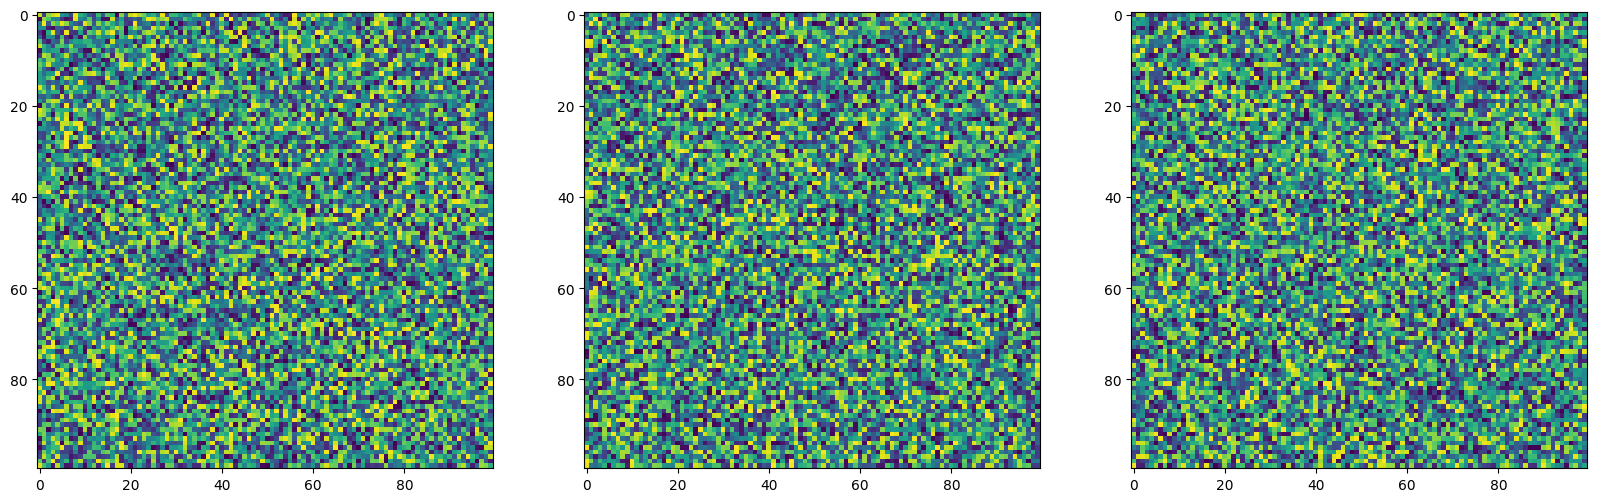

In [14]:
fig, axs = plt.subplots(1,3,figsize=(20,10)) # Here we're making 1 row of 3 columns of subplots

for band in [1,2,3]: # Iterate over band indices 1, 2, and 3
    arr = r100_r3d.read(band) # get the array associated with that band index
    axs[band-1].imshow(arr) # Because the sublots are 0-indexed we have have to subtract 1

We can make this even more interpreable by adding a colorbar.

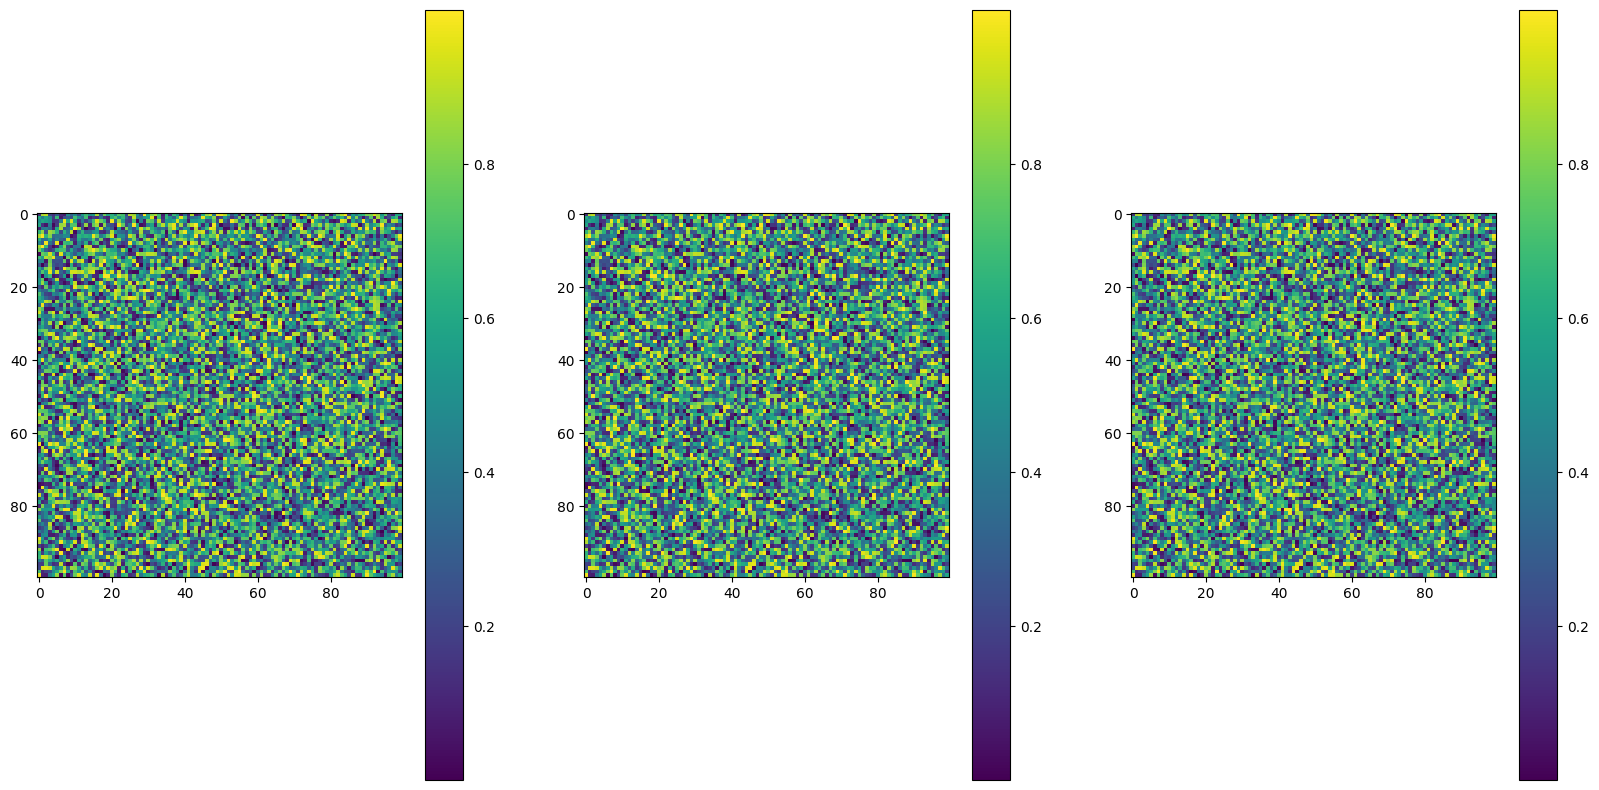

In [18]:
fig, axs = plt.subplots(1,3,figsize=(20,10)) # Here we're making 1 row of 3 columns of subplots

for band in [1,2,3]: # Iterate over band indices 1, 2, and 3
    im = axs[band-1].imshow(arr)  # Save the imshow output to a variable
    plt.colorbar(im, ax=axs[band-1])  # Pass that variable and the subplot axis

## Dynamic fields

If we think about how we could visualize dynamic fields, one way is just as we did above! Since in a dynamic field the bands represent time-steps, each subplot would represet a different moment in time. We can also visualize small-ish portions of the raster as collections of time series. I'll give an example here.

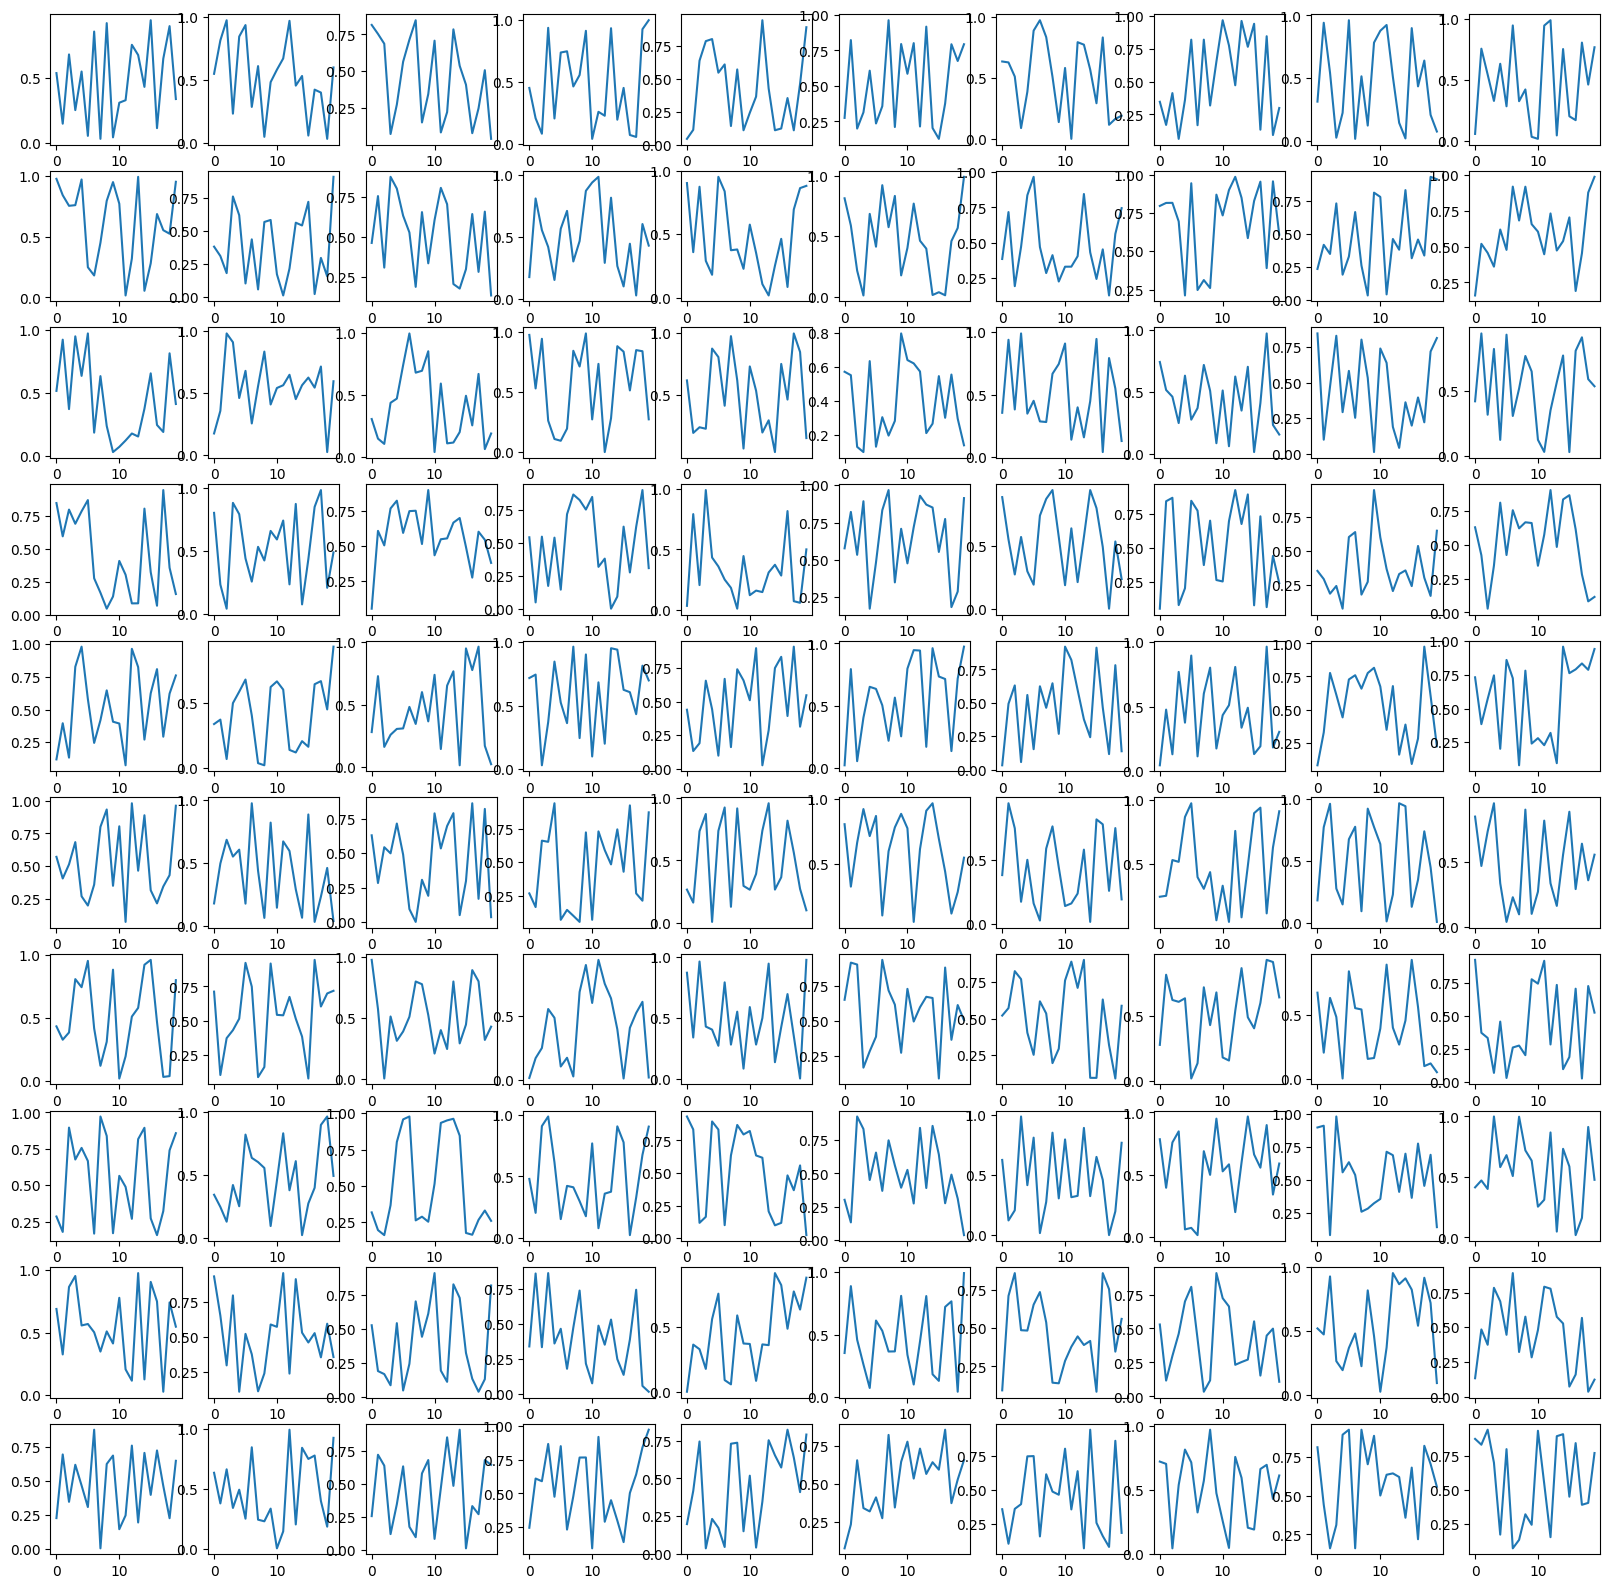

In [29]:
dyn_field = np.random.rand(10,10,20) # 10 x 10 raster with 20 time steps

fig, axs = plt.subplots(10,10,figsize=(20,20)) # Here we're making a 10 x 10 grid of plots, each subplot representing one pixel

for r in range(0,10): # range lets us access all numbers between 0 and 10 (Excluding 10). This will be rows
    for c in range(0,10): # now columns
        # when "slicing" a numpy array a:b means "from a to b". Omitting a or b means go to the end, so : is all elements
        field_rc = dyn_field[r,c,:] 

        axs[r,c].plot(range(0,20),field_rc) # Plot the time series associate with row r, column c in the subplot in the same position
    

# Velocity fields

Recall from class on Tuesday that velocity fields are vector fields with the special interpretation of the vector representing motion. This is often easiest to visualize with arrows, like the example we drew in class. We can use matplotlib's `quiver` plot to make visualizations like that.

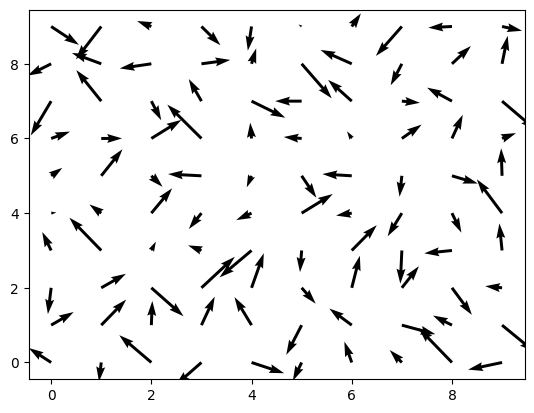

In [32]:
wind_dir = np.random.rand(10,10,2)-0.5 # 2 wind direction components, subtract 0.5 so values are in [-0.5,0.5]
plt.quiver(wind_dir[:,:,0],wind_dir[:,:,1])

## A note on dynamic vector fields

Dynamic vector fields can be particularly tricky to visualize because they have 4 dimensions. Perhaps the easiest way is to make collections of time series, as we did above, but have a separate line for each element of the vector. This has the unfortunate feature of requiring that each variable be in a similar scale. Another way is to plot each variable at each time step. That is, you could have a grid where moving along the x-axis of plots is moving in time and moving along the y-axis is changing variables. Visualizing data in more than 3 dimensions is hard and often requires a particular solution to make a satisfying result.

## Aggregation

Now that we've gone over how to visualize the various forms of vector fields, let's talk about how to aggregate data represented in those fields to geometries. In last Thursday's notebook we saw how to mask a raster with a shapely geometry, which is the first step. Let's re-do that here.

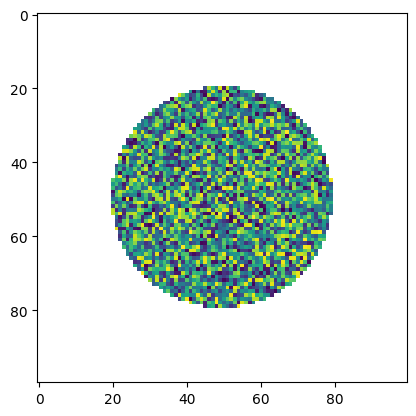

In [33]:
r100_r = rio.open("./r100.tif")

gs_masked2, _ = mask(r100_r,# the raster we want to mask
    [shg.Point(50,-50).buffer(30)], # We'll intersect with a circle of radius 30 centered at 50,-50. It needs to be in a list!
    nodata = np.nan # to make it more clear, we'll put nans where there isn't an intersection
    )

plt.imshow(gs_masked2[0,:,:]) # It adds a first index

`gs_masked2` is the masked array, with masked out positions in the raster assigned `NaN`. Let's say we wanted to average those values. We could take the average of the array, ignoring `NaN`s to get the result we want. There are at least two ways to do this. The first is to explicitly select positions in the array where the value is not `NaN` and average those.

In [36]:
np.mean( # Take the mean
    gs_masked2[~np.isnan(gs_masked2)] # Of values in gs_masked2 where gs_masked2 is not NaN 
    # ~ or ! means not
)

np.float64(0.503731064547132)

The other way is to use a specialized function, `np.nanmean`, which just ignores `NaN`s.

In [37]:
np.nanmean(gs_masked2)

np.float64(0.5037310645471319)

If we try just taking the mean, we'll get `NaN`.

In [38]:
np.mean(gs_masked2)

np.float64(nan)

There are many other numpy aggregation functions like `np.min`, `np.std`, etc. Often, these have a "nan" version as well.

Now let's do an example with a `geopandas.GeoDataFrame`, where we aggregate across many different geometries. Let's start by making a data frame of small circles.

In [45]:
df = pd.DataFrame({
    'x' : np.arange(10,90,10), # np.arange gives evenly spaced values starting at the 1st arg, ending at 2nd, in steps of the 3rd
    'y' : -1*np.arange(10,90,10) # Need to multiply by -1 becase our raster NS values go down from 0
})
df['circ'] = df.apply(lambda x: shg.Point(x['x'],x['y']).buffer(3),axis=1) # Radius 3 circle centered at the point x, y
df

,x,y,circ
0,10,-10,"POLYGON ((13 -10, 12.98555418001659 -10.294051..."
1,20,-20,"POLYGON ((23 -20, 22.985554180016592 -20.29405..."
2,30,-30,"POLYGON ((33 -30, 32.98555418001659 -30.294051..."
3,40,-40,"POLYGON ((43 -40, 42.98555418001659 -40.294051..."
4,50,-50,"POLYGON ((53 -50, 52.98555418001659 -50.294051..."
5,60,-60,"POLYGON ((63 -60, 62.98555418001659 -60.294051..."
6,70,-70,"POLYGON ((73 -70, 72.98555418001659 -70.294051..."
7,80,-80,"POLYGON ((83 -80, 82.98555418001659 -80.294051..."


<Axes: >

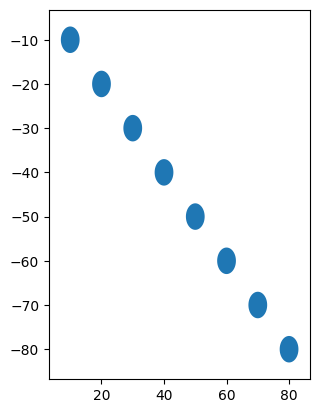

In [46]:
gdf = gpd.GeoDataFrame(df,geometry='circ',crs="EPSG:4326")
gdf.plot()

Now we need a concise way to mask the raster to each circle, aggregate the values (let's sum them this time), and assign it to a new column of `gdf`. For this we'll use a function, a piece of code that takes arguments we choose and returns the result. Like with loops, python uses whitespace to know where the function ends.

In [44]:
r100_r

<open DatasetReader name='./r100.tif' mode='r'>

In [47]:
def agg_sum(geom): # We're defining a function called agg_sum that takes an argument that we'll call geom
    masked_r, _ = mask(r100_r,[geom],nodata=np.nan) # Mask the r100_r raster with circ
    return(np.nansum(masked_r)) # Return the sum of the non-NaN values of the masked array

gdf['raster_sum'] = gdf['circ'].apply(agg_sum) # Here, we only have one argument, so we can apply agg_sum just to the circ column
gdf

,x,y,circ,raster_sum
0,10,-10,"POLYGON ((13 -10, 12.98555 -10.29405, 12.94236...",17.234565
1,20,-20,"POLYGON ((23 -20, 22.98555 -20.29405, 22.94236...",15.956767
2,30,-30,"POLYGON ((33 -30, 32.98555 -30.29405, 32.94236...",13.962913
3,40,-40,"POLYGON ((43 -40, 42.98555 -40.29405, 42.94236...",14.155645
4,50,-50,"POLYGON ((53 -50, 52.98555 -50.29405, 52.94236...",16.104709
5,60,-60,"POLYGON ((63 -60, 62.98555 -60.29405, 62.94236...",14.948105
6,70,-70,"POLYGON ((73 -70, 72.98555 -70.29405, 72.94236...",15.809977
7,80,-80,"POLYGON ((83 -80, 82.98555 -80.29405, 82.94236...",19.709069


<Axes: >

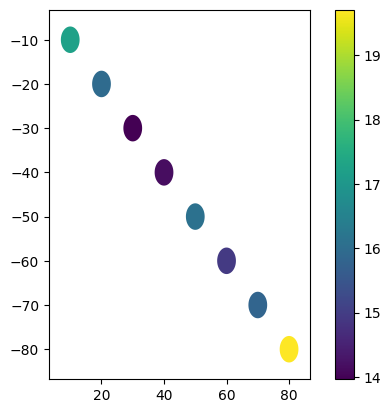

In [48]:
gdf.plot(column='raster_sum',legend=True)

We can get a sense that this is correct by just masking the raster

In [ ]:
test_mask, _ = mask(r100_r,[gdf['circ'].to_list()],nodata=np.nan)